In [1]:
%load_ext autoreload
%autoreload 2

## Initial Code Setup

In [2]:
#Import Packages
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython: from IPython import display

import os

from itertools import count
from collections import deque

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

#Import custom classes
from Source.NN_model_2 import QNetwork
from Source.dqn_agent_2 import Agent, ReplayBuffer, EpsilonGreedyStrategy
from Source.Env_Manager import EnvManager
from Source.Misc import plot

import tqdm
from tqdm import tnrange, tqdm_notebook
from time import sleep

In [3]:
#Hyper-parameters
BUFFER_SIZE = int(1e5)      #replay buffer size
BATCH_SIZE = 60             #minibatch size
GAMMA = 0.999                #discount factor
LR = 5e-4                   #learning rate
UPDATE_EVERY = 50            #how often to update the network
SEED = 0                    #random seed number

TAU = 1e-3                  #for soft update of target parameters
EPS_START = 1
EPS_END = 0.01
EPS_DECAY = 0.9983 #125e-6
EPISODE_STEP_LIMIT = 50
TRAIN_EPISODES = 2500
TEST_EPISODES = 20

#Choose the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



def Initialize_Setup():
    #Choose the environment
    em = EnvManager(device, 'uav-v3', SEED)
    available_actions = em.num_actions_available()
    random.seed(SEED)

    #Select the strategy
    strategy = EpsilonGreedyStrategy(EPS_START, EPS_END, EPS_DECAY)

    #Initialize the agent
    agent = Agent(strategy, available_actions, SEED, device)

    #Instantiate MemoryBuffer
    memory = ReplayBuffer(available_actions, BUFFER_SIZE, BATCH_SIZE, SEED, device)

    policy_net = QNetwork(available_actions, SEED).to(device)
    target_net = QNetwork(available_actions, SEED).to(device)
    print(policy_net)

    #Initialize target_net weights to policy_net weights
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval() #Set the target_net in eval mode

    #Select the optimizer
    optimizer = optim.Adam(params=policy_net.parameters(), lr=LR)
    return em, strategy, agent, memory, policy_net, target_net, optimizer

em, strategy, agent, memory, policy_net, target_net, optimizer = Initialize_Setup()
measure = 'rate_thr_path'

QNetwork(
  (fc1): Linear(in_features=2, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=32, bias=True)
)


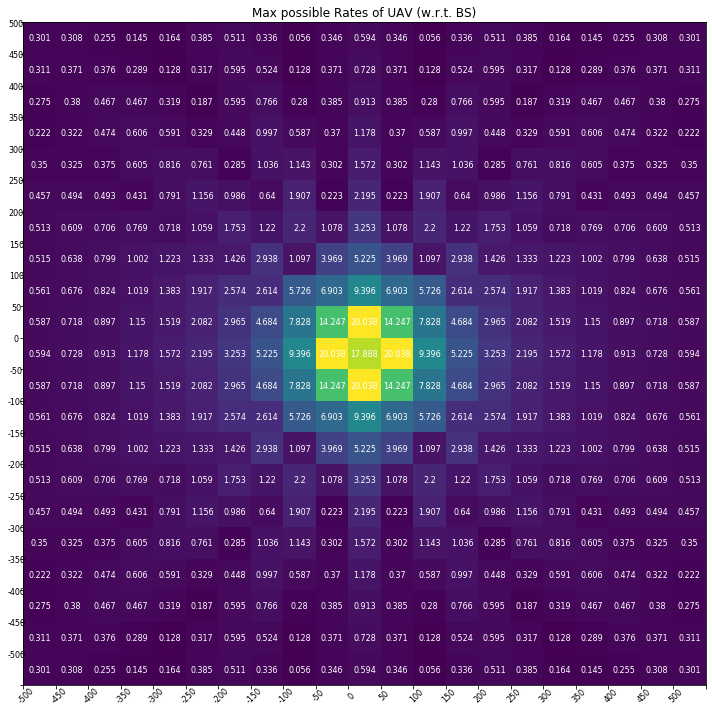

In [4]:
exh_rates_fname = 'env_exh_rates.txt'
ue_xloc = em.env.ue_xloc  #20 locs
ue_yloc = em.env.ue_yloc[::-1]     #20 locs

if os.path.exists(exh_rates_fname):
    rate_arr = np.loadtxt(exh_rates_fname, dtype=float)
else:
    # File is empty
    rate_tr = 0.0
    t_step = 0

    rate_arr = np.zeros([(max(ue_yloc)-min(ue_yloc))//50 +1, (max(ue_xloc)-min(ue_xloc))//50 + 1]) #(-500,50) -----> (500,500)
    for y_ndx in range(len(ue_yloc)):
        for x_ndx in range(len(ue_xloc)):
            state = np.array([ue_xloc[x_ndx], ue_yloc[y_ndx]])/ em.env.high_obs
            exh_bdir,exh_rate = em.env.get_Exh_Rate(state)
            rate_arr[y_ndx,x_ndx] = np.around(exh_rate, decimals=3)
    np.savetxt(exh_rates_fname, rate_arr, fmt='%f')

row_labels = [str(x) for x in ue_yloc]
col_labels = [str(x) for x in ue_xloc]

fig, ax = plt.subplots(1,1, figsize=(10,10))
im = ax.imshow(rate_arr, aspect='auto')

# We want to show all ticks...
ax.set_xticks(np.arange(rate_arr.shape[1]+1)-.5)
ax.set_yticks(np.arange(rate_arr.shape[0]+1)-.5)
# ... and label them with the respective list entries
ax.set_xticklabels(col_labels, fontsize=8)
ax.set_yticklabels(row_labels, fontsize=8)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="center",
         rotation_mode="anchor")
plt.setp(ax.get_yticklabels(), rotation=0, ha="center",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(rate_arr.shape[0]):
    for j in range(rate_arr.shape[1]):
        text = ax.text(j, i, rate_arr[i, j],
                       ha="center", va="center", color="w", fontsize=8)

ax.set_title("Max possible Rates of UAV (w.r.t. BS)")
fig.tight_layout()
plt.show()    



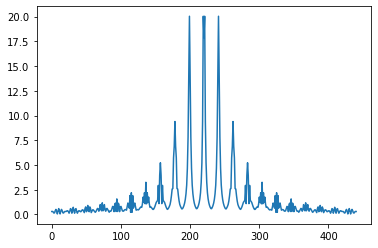

In [5]:
rate_arr = rate_arr.flatten()

plt.plot(rate_arr)
plt.show()

In [6]:
def get_moving_average(period, values):
    values = torch.tensor(values, dtype=torch.float)
    if len(values) >= period:
        moving_avg = values.unfold(dimension=0, size=period, step=1).mean(dim=1).flatten(start_dim=0)
        moving_avg = torch.cat((torch.zeros(period-1), moving_avg))
        return moving_avg.numpy()
    else:
        moving_avg = torch.zeros(len(values))
        return moving_avg.numpy()

In [7]:
def Training_Loop(policy_net, target_net, memory, em, agent, optimizer, train_episodes, rate_thr, rate_ndx, measure):
    episode_durations = []
    episode_rewards = []
    policy_net.train()

    outer = tqdm.tqdm_notebook(total=train_episodes, desc='rate_thr: {0}-training loop: '.format(rate_ndx), position=0)

    for episode in range(train_episodes):
        #Set the rate requirement and reset environment
        state = em.reset(rate_thr, measure)
        
        ep_loss, ep_rwd, timestep = 0.0, 0.0, 0

        #Count the steps in agent
        agent.current_step +=1
        for timestep in count():
            action = agent.act(state, policy_net)
            next_state, reward, done, _ = em.step(action)
            ep_rwd += reward.item()
            memory.add(state, action, reward, next_state, done)

            state = next_state

            if memory.can_provide_sample():
                experiences = memory.sample()
                states, actions, rewards, next_states, dones = experiences

                current_q_values = policy_net(states).gather(1,index=actions.unsqueeze(-1))
                next_q_values = target_net(next_states).detach().max(1)[0]
                target_q_values = (next_q_values*GAMMA) + rewards

                loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
                ep_loss += loss.item()

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            if (timestep==EPISODE_STEP_LIMIT) or done:
                episode_durations.append(timestep)
                episode_rewards.append(ep_rwd)
                print('\rEpisode {}\t timestep: {}, Score: {:.2f}, eps: {}'.format(episode+1, timestep, ep_rwd, agent.strategy.get_exploration_rate(agent.current_step)), end="\r")
                break

        if episode % UPDATE_EVERY == 0:
            target_net.load_state_dict(policy_net.state_dict())
            
        # update tqdm outer progress bar
        outer.update(1)
    torch.save(policy_net.state_dict(), 'model_rate_thr_300919_{0}.pth'.format(rate_ndx))
    return episode_rewards, episode_durations

## 1. Training over different rate threshold

rate_threshold:  0.28
QNetwork(
  (fc1): Linear(in_features=2, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=32, bias=True)
)


Episode 2500	 timestep: 12, Score: 6.35, eps: 0.0142127390635310822



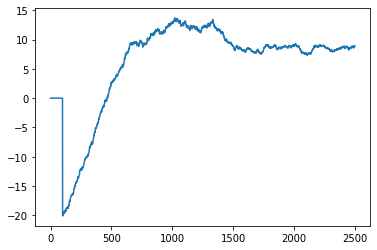

rate_threshold:  1.156
QNetwork(
  (fc1): Linear(in_features=2, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=32, bias=True)
)


Episode 2500	 timestep: 32, Score: 0.38, eps: 0.01421273906353108246



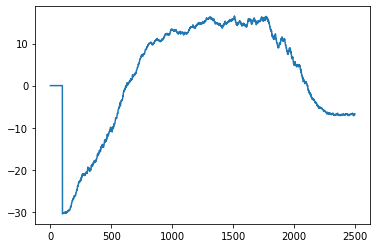

rate_threshold:  5.726
QNetwork(
  (fc1): Linear(in_features=2, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=32, bias=True)
)


Episode 2500	 timestep: 15, Score: -12.21, eps: 0.014212739063531082



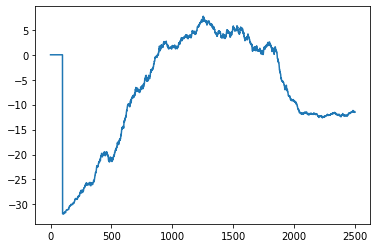

In [8]:
rate_thr_indices = [50, 120, 180]
rate_thr_rwd_fname = 'rate_thr_rewards.txt'
rate_thr_dur_fname = 'rate_thr_durations.txt'
measure = 'rate_thr_path'

rate_thr_episode_rewards = []
rate_thr_episode_durations = []
for rate_ndx in rate_thr_indices:
    print("rate_threshold: ", rate_arr[rate_ndx])
    
    #Re-Initialize Setup
    em, strategy, agent, memory, policy_net, target_net, optimizer = Initialize_Setup()
    rate_thr = rate_arr[rate_ndx]
    
    #Training Loop
    episode_rewards, episode_durations = Training_Loop(policy_net, target_net, memory,em, agent, optimizer, TRAIN_EPISODES, rate_thr, rate_ndx, measure)
    
    print("\n")
    rate_thr_episode_rewards.append(episode_rewards)
    rate_thr_episode_durations.append(episode_durations)
    moving_avg = get_moving_average(100, episode_rewards)
    plt.plot(moving_avg)
    plt.show()

np.savetxt(rate_thr_rwd_fname, np.array(rate_thr_episode_rewards), fmt='%f')
np.savetxt(rate_thr_dur_fname, np.array(rate_thr_episode_durations), fmt='%f')



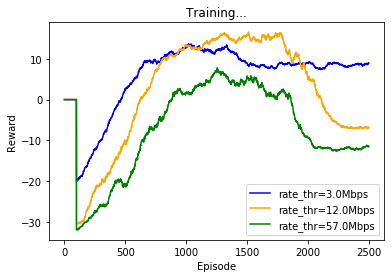

In [9]:
#Plot the figures
plt.figure()
plt.clf()
plt.title('Training...')
plt.xlabel('Episode')
plt.ylabel('Reward')
moving_avg_period = 100

moving_avg0 = get_moving_average(moving_avg_period, rate_thr_episode_rewards[0])
plt.plot(moving_avg0, color='blue', label='rate_thr={0}Mbps'.format(np.around(10*rate_arr[rate_thr_indices[0]]), decimals=2))

moving_avg1 = get_moving_average(moving_avg_period, rate_thr_episode_rewards[1])
plt.plot(moving_avg1, color='orange', label='rate_thr={0}Mbps'.format(np.around(10*rate_arr[rate_thr_indices[1]]), decimals=2))


moving_avg2 = get_moving_average(moving_avg_period, rate_thr_episode_rewards[2])
plt.plot(moving_avg2, color='green', label='rate_thr={0}Mbps'.format(np.around(10*rate_arr[rate_thr_indices[2]]), decimals=2))    

plt.legend()
plt.show()

## 2. Path plot rate_threshold vs shortest path vs rate path

In [9]:
#rate_threshold path
rate_ndx = 50 #3 Mbps
#Re-Initialize Setup
em, strategy, agent, memory, policy_net, target_net, optimizer = Initialize_Setup()
rate_thr = rate_arr[rate_ndx]
measure = 'rate_thr_path'
#Training Loop
rate_thr_episode_rewards, rate_thr_episode_durations = Training_Loop(policy_net, target_net, memory, em, agent, optimizer, TRAIN_EPISODES, rate_thr, rate_ndx, measure)
print("\n")
rate_thr_path_rates = em.env.ue_path_rates
rate_thr_path = em.env.ue_path_rates
#-------------------------------------------------------------------------------------------------------------------------------
#shortest path

#Re-Initialize Setup
em, strategy, agent, memory, policy_net, target_net, optimizer = Initialize_Setup()
rate_thr = rate_arr[rate_ndx]
measure = 'short_path'
#Training Loop
short_episode_rewards, short_episode_durations = Training_Loop(policy_net, target_net, memory, em, agent, optimizer, TRAIN_EPISODES, rate_thr, rate_ndx, measure)
print("\n")
short_path_rates = em.env.ue_path_rates
short_path = em.env.ue_path_rates

#------------------------------------------------------------------------------------------------------------------------------
#Rate Path

#Re-Initialize Setup
em, strategy, agent, memory, policy_net, target_net, optimizer = Initialize_Setup()
rate_thr = rate_arr[rate_ndx]
measure = 'rate_path'

#Training Loop
rate_episode_rewards, rate_episode_durations = Training_Loop(policy_net, target_net, memory, em, agent, optimizer, TRAIN_EPISODES, rate_thr, rate_ndx, measure)
print("\n")
rate_path_rates = em.env.ue_path_rates
rate_path = em.env.ue_path_rates

QNetwork(
  (fc1): Linear(in_features=2, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=32, bias=True)
)


Episode 2500	 timestep: 21, Score: 10.08, eps: 0.014212739063531082

QNetwork(
  (fc1): Linear(in_features=2, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=32, bias=True)
)


Episode 2500	 timestep: 12, Score: 3.40, eps: 0.014212739063531082

QNetwork(
  (fc1): Linear(in_features=2, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=32, bias=True)
)


Episode 2500	 timestep: 17, Score: 8.52, eps: 0.0142127390635310824



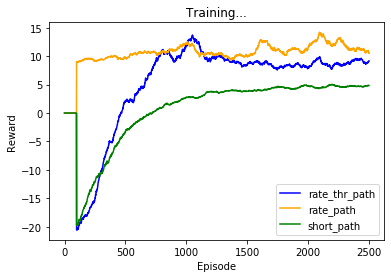

In [10]:
#Plot the figures
plt.figure()
plt.clf()
plt.title('Training...')
plt.xlabel('Episode')
plt.ylabel('Reward')
moving_avg_period = 100

moving_avg0 = get_moving_average(moving_avg_period, rate_thr_episode_rewards)
plt.plot(moving_avg0, color='blue', label='rate_thr_path')

moving_avg1 = get_moving_average(moving_avg_period, rate_episode_rewards)
plt.plot(moving_avg1, color='orange', label='rate_path')


moving_avg2 = get_moving_average(moving_avg_period, short_episode_rewards)
plt.plot(moving_avg2, color='green', label='short_path')    

plt.legend()
plt.show()

In [ ]:
## 3. No. of steps done vs rate threshold (between same source and destination)

In [ ]:
## 4. Performance Score vs rate threshold, Efficiceny score vs rate threshold (over episode #)